In [1]:
import gsc
import numpy as np
import re

# Just terminals are similar, agreement is probabilistic for SP

In [2]:
# Set up grammar

# Structure of NPs
# Background: frequencies per million in corpora
# NP -> N N .02  [Biber, Grieve, & Iberri-Shea, 2009, Figure 9.2]
# NP -> N RC .005  [Roland, Dick & Elman, 2007, also Biber et al. Figure 9.2]
# NP -> Det N .05  https://books.google.com/ngrams/graph?content=_DET_+_NOUN_%2C_DET_+_ADJ_+_NOUN_&year_start=1990&year_end=2000&corpus=15&smoothing=0&share=&direct_url=t1%3B%2C_DET_%20_NOUN_%3B%2Cc0%3B.t1%3B%2C_DET_%20_ADJ_%20_NOUN_%3B%2Cc0

# re-normalize,
# NP -> N N .27
# NP -> N RC .06
# NP -> N .67

# Grammar distinguishes complex NPs (two words) vs. simplex NPs (one word).
# Combining first 2 NP expansions above gives
# NP -> NPC .33
# renormalizing complex NPs
# NPC -> N N .82
# NPC -> N RC .18

# Number morphology of NPs: Singular 2/3, Plural 1/3 [Laurel's calculations from COCA -- see PPT file]
# In simple noun phrases and relative clauses, assume that grammatical number follows number morphology.

# For complex NPs, following Haskell, Thornton, & MacDonald (2010), assume some mistmatches for Ns Np.
# 80% match of these NPs are grammatically singular, 20% are grammatically plural.

# To adjust the PCFG probabilities, we start with the probability of Ns Np assuming no mismatches
# S->NPCs Vs .22 * NPCs -> Ns Np .27 = .059
# To reduce this by 20%, we would decrease the probability by .012
# This probability must then be shifted from NPCs to NPCp

# We therefore reduce the probability of S -> NPCs Vs by .012 (from .22 to .21, rounding)
# The probability of S -> NPCp Vp is increased by .012 (from .11 to .12)
# We add a new rule, NPCp -> Ns Np with probability .10 (=.012/.12, so that this structure has probability .012)
# To acommodate this new rule, the probability of other complex nP expansions of NPCp are then decreased 
# with the .10 probability divided in proportion to the relative probability of each expansion
# With no mismatched, NPCp -> Np Ns = .54; NPCp -> Np Np = .27 (total probability .81)
# Np Ns is reduced to .47 (.54/.81 * .10) and Np Np is reduced to .24 (.27/.81 * .10)



PCFG = '''



0.44 S -> Ns Vs  # .S expansions
0.22 S -> Np Vp    
0.208 S -> NPCs Vs  
0.122 S -> NPCp Vp
0.54 NPCs -> Ns Ns  #NPCs expansions
0.27 NPCs -> Ns Np
0.18 NPCs -> Ns RC
0.47 NPCp -> Np Ns   #NPCp expansions
0.24 NPCp -> Np Np
0.10 NPCp -> Ns Np
0.18 NPCp -> Np RC
0.66 RC -> Ns Vs     #RC expansions
0.33 RC -> Np Vp
'''

ROOT = 'S'
MAXLEN = 4

In [3]:
## display fillers
hg = gsc.HarmonicGrammar(pcfg=PCFG, root=ROOT, max_sent_len=MAXLEN)

print(hg.filler_names)


['#:0', '*@:1', '*Np:0', '*Ns:0', '*Vp:1', '*Vs:1', '@:1', 'NPCp[1]:0', 'NPCp[2]:0', 'NPCp[3]:0', 'NPCp[4]:0', 'NPCs[1]:0', 'NPCs[2]:0', 'NPCs[3]:0', 'Np:0', 'Np:1', 'Ns:0', 'Ns:1', 'RC[1]:1', 'RC[2]:1', 'S[1]:0', 'S[2]:0', 'S[3]:0', 'S[4]:0', 'Vp:1', 'Vs:1', '_']


In [4]:
## display probabilities of each sentence
hg.g0.read_rules()

(0.4747) NPCp[1]:0 -> Np:0 Ns:1
(0.2424) NPCp[2]:0 -> Np:0 Np:1
(0.1010) NPCp[3]:0 -> Ns:0 Np:1
(0.1212) NPCp[4]:0 -> Np:0 RC[1]:1
(0.0606) NPCp[4]:0 -> Np:0 RC[2]:1
(0.5455) NPCs[1]:0 -> Ns:0 Ns:1
(0.2727) NPCs[2]:0 -> Ns:0 Np:1
(0.1212) NPCs[3]:0 -> Ns:0 RC[1]:1
(0.0606) NPCs[3]:0 -> Ns:0 RC[2]:1
(0.6667) RC[1]:1 -> Ns:0 Vs:1
(0.3333) RC[2]:1 -> Np:0 Vp:1
(0.4444) S[1]:0 -> Ns:0 Vs:1
(0.2222) S[2]:0 -> Np:0 Vp:1
(0.1146) S[3]:0 -> NPCs[1]:0 Vs:1
(0.0573) S[3]:0 -> NPCs[2]:0 Vs:1
(0.0382) S[3]:0 -> NPCs[3]:0 Vs:1
(0.0585) S[4]:0 -> NPCp[1]:0 Vp:1
(0.0299) S[4]:0 -> NPCp[2]:0 Vp:1
(0.0124) S[4]:0 -> NPCp[3]:0 Vp:1
(0.0224) S[4]:0 -> NPCp[4]:0 Vp:1


In [5]:
# Create a list of pairwise filler similarity (dot product) 
# Increase similarity of sing/plural

sim = hg.get_simlist(dp=0.0) # all symbols of same type have similarity 0.2
sim.extend(([['Np:0', 'Ns:0'], 0.5],  # nouns differing in number have similarity 0.5
           [['Np:1', 'Ns:1'], 0.5],
           [['Vp:1', 'Vs:1'], 0.0]))  # verbs differing in number have similarity 0.0 (and verbs are always right child)

In [6]:
sim

[[['NPCp[1]:0', 'NPCp[2]:0'], 0.0],
 [['NPCp[1]:0', 'NPCp[3]:0'], 0.0],
 [['NPCp[1]:0', 'NPCp[4]:0'], 0.0],
 [['NPCp[2]:0', 'NPCp[3]:0'], 0.0],
 [['NPCp[2]:0', 'NPCp[4]:0'], 0.0],
 [['NPCp[3]:0', 'NPCp[4]:0'], 0.0],
 [['NPCs[1]:0', 'NPCs[2]:0'], 0.0],
 [['NPCs[1]:0', 'NPCs[3]:0'], 0.0],
 [['NPCs[2]:0', 'NPCs[3]:0'], 0.0],
 [['RC[1]:1', 'RC[2]:1'], 0.0],
 [['S[1]:0', 'S[2]:0'], 0.0],
 [['S[1]:0', 'S[3]:0'], 0.0],
 [['S[1]:0', 'S[4]:0'], 0.0],
 [['S[2]:0', 'S[3]:0'], 0.0],
 [['S[2]:0', 'S[4]:0'], 0.0],
 [['S[3]:0', 'S[4]:0'], 0.0],
 [['Np:0', 'Ns:0'], 0.5],
 [['Np:1', 'Ns:1'], 0.5],
 [['Vp:1', 'Vs:1'], 0.0]]

In [7]:
## set up this network
net_opts = {
    'T_init': 1e-2,     # update noise (default = 1e-3)
    'q_max': 15.,       # maximum q value (default = 20)
    'use_runC': True,   # faster simulation (default = False)
}

net = gsc.GscNet(hg=hg,encodings={'similarity': sim},
                 opts=net_opts, seed=1024)
net.generate_corpus(use_freq=True)


0.02270197868347168 s for generating encodings
0.09643697738647461 s for initializing parameter values
0.5410017967224121 s for finding a global equilibrium point


In [8]:
## target probabilities in network
for si, sent in enumerate(net.corpus['sentence']):
    sent = [bname.split('/')[0] for bname in sent]
    pval = '{0:.{1}f}'.format(net.corpus['prob_sent'][si], 4)  # decimals
    print('Sentence {:d}: p = {} ({})'.format(si, pval, ' '.join(sent)))

Sentence 0: p = 0.4344 (Ns Vs)
Sentence 1: p = 0.2270 (Np Vp)
Sentence 2: p = 0.1192 (Ns Ns Vs)
Sentence 3: p = 0.0572 (Ns Np Vs)
Sentence 4: p = 0.0570 (Np Ns Vp)
Sentence 5: p = 0.0304 (Np Np Vp)
Sentence 6: p = 0.0286 (Ns Ns Vs Vs)
Sentence 7: p = 0.0148 (Np Ns Vs Vp)
Sentence 8: p = 0.0126 (Ns Np Vp)
Sentence 9: p = 0.0112 (Ns Np Vp Vs)
Sentence 10: p = 0.0076 (Np Np Vp Vp)


In [9]:
## set up network for training
train_opts = {
    'lrate': 0.1,
    'num_trials': 100,          # Number of (production) trials per iteration.
    'ema_stat_weight': 0.5,  # Weight for exponential moving average of model prob dist
                              # The larger the value is, the less the model learns from each iteration 
                              # default = 0
    'trace_varnames': ['kl_trees', 'kl_treelets', 'prob_sent', 'acc'],
    'report_cycle': 5,        # report after every N iterations (epochs) (default=1)
    
    'init_noise_mag': 0.02,        # default values
    'average_weight': False,       # weight sharing (default=False)
    'average_filler_bias': False,  # bias sharing (default=False)
                                   # exception: bias values of illegitimate fillers are fixed
}

net.initialize(train_opts=train_opts)

In [10]:
## train network
for _ in range(0, 10):
    net.train2(train_opts={'num_epochs': 10},   # possible to overwrite other parameters (e.g., ema_stat_weight)
               savefilename='s00Gram_nSim50_vSim00.pkl')   # save/overwrite data after every 10 epoch
    
# REPORT format
# [epoch_num] KL_divergence | GP_prob (Q; up to 6 trees) | prod_acc | max_abs_dWC (ignore the final column)

[0005]   28.098 | 0.000 0.000 0.000 0.126 0.000 0.095 | 0.445 | 0.661 0.000
[0010]    6.154 | 0.510 0.275 0.000 0.004 0.000 0.003 | 0.845 | 0.176 0.000
[0015]    2.195 | 0.428 0.207 0.071 0.014 0.000 0.001 | 0.758 | 0.120 0.000
[0020]    0.272 | 0.427 0.238 0.045 0.056 0.021 0.012 | 0.843 | 0.107 0.000
[0025]    0.159 | 0.392 0.210 0.113 0.078 0.013 0.019 | 0.902 | 0.060 0.000
[0030]    0.170 | 0.435 0.191 0.112 0.048 0.015 0.015 | 0.896 | 0.054 0.000
[0035]    0.179 | 0.429 0.199 0.095 0.035 0.031 0.011 | 0.860 | 0.053 0.000
[0040]    0.098 | 0.433 0.212 0.079 0.048 0.056 0.020 | 0.917 | 0.039 0.000
[0045]    0.136 | 0.421 0.194 0.102 0.026 0.037 0.026 | 0.896 | 0.036 0.000
[0050]    0.129 | 0.483 0.178 0.108 0.035 0.043 0.016 | 0.924 | 0.061 0.000
[0055]    0.080 | 0.410 0.287 0.058 0.054 0.045 0.034 | 0.967 | 0.062 0.000
[0060]    0.082 | 0.455 0.223 0.096 0.066 0.040 0.017 | 0.944 | 0.027 0.000
[0065]    0.096 | 0.434 0.230 0.097 0.059 0.035 0.009 | 0.935 | 0.037 0.000
[0070]    0.

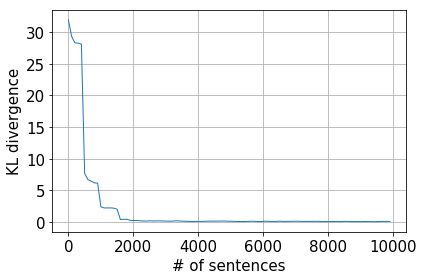

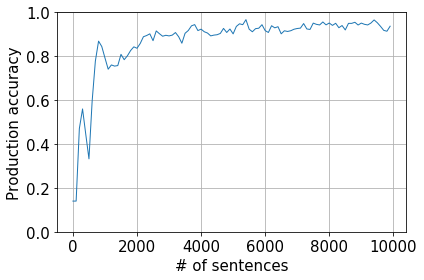

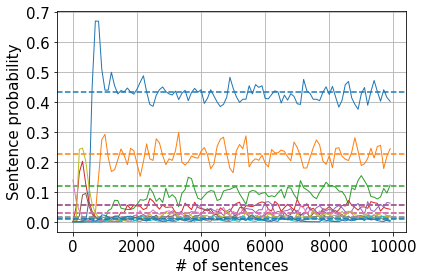

In [11]:
## plot results of training
net = gsc.load_model('s00Gram_nSim50_vSim00.pkl')

gsc.plot_train_result(net, legend=False, linewidth=1)